# 5-number summary

This tutorial is meant to help to load, visualise and analyse datasets in order to prepare them for the data pre-processing

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#to save the plots to a pdf file
from matplotlib.backends.backend_pdf import PdfPages

## General variables configuration

In [2]:
# dataset name and location
dataset_folder = '/content/Bristol_owd.csv'

# results folder
res_folder = '/content/'

# selecting the features and the time column
    # only the features related to the weather that are measurements are selected. That is, features that contains
    #  _id, _main, _description, and _icon are removed since they are use by open weather internally
    # the city name, lat, lon, and timezone can be safely removed since we have the files separated by city
    # we have two times format (dt and dt_iso). We select dt since it is the time in numeric format
fetures_to_preserve = ['temp', 'temp_min', 'temp_max', 'feels_like','pressure', 'humidity', 'wind_speed', 'wind_deg',
                       'clouds_all', 'Rain_id', 'Rain_main', 'Rain_description']

# features to ignore when performing the frequency counts
ignore_features = ['temp_min', 'temp_max']

######################################## Global variables ########################################
# original datasets
original_data = None

# datasets with the features of interest
new_dataset = None

# summary of nan values per feature
nan_summary = {}

# Give format to the features names as appears in the paper proposal
formated_features_names = []

## Functions

In [3]:
# Load all the datasets
def load_dataset():
  global original_data
  original_data = pd.read_csv(dataset_folder, sep = ",", error_bad_lines=False, dtype='str')

# Generate the new dataset
def build_new_dataset():
  global new_dataset
  global original_data
  #format the new structure of the data(dataframe)
  data_format = pd.DataFrame()
  # append the features previously selected (without the time column)
  data_format = original_data[fetures_to_preserve]
  # append the column time
  data_format.index = original_data['dt']
  new_dataset = data_format

# Compute a summary for all nan values per feature per dataset
def compute_nan_summary(dataset):
  global nan_summary
  print('Computing Nan summary')
  summary = {}
  for feature in list(dataset.columns):
      na_total = dataset[feature].isnull().sum()
      na_percentage = (na_total*100)/len(dataset.index)

      summary[feature] = [na_total, na_percentage]

  nan_summary = pd.DataFrame(summary, columns = list(dataset.columns), index = ['Na No', 'Na %'])

# Write the nan summary resutls as a Excel file
def write_nan_summary():
  with pd.ExcelWriter(res_folder + 'Nan_summary.xlsx') as writer:
    nan_summary.to_excel(writer, sheet_name='values')

# Plot the behaviour of the features across time
def plot_feats_across_time(dataset):
  print('Ploting features behaviour')

  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  plots_output = res_folder + 'features_across_time.pdf'
  #taking a look of the features variation across time
  plt.rcParams["figure.figsize"] = (20,30)
  dataset.plot(subplots=True)
  plt.savefig(plots_output)
  plt.close('all')

# Compute the 5-number summary
def five_number_summary(dataset):
  print('Computing the 5-number summary')

  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  with pd.ExcelWriter(res_folder + '5_number_summary.xlsx') as writer:
    #minimum
    dataset_min = dataset.min()
    #lower quartile
    dataset_lq = dataset.quantile(.25, axis = 0)
    #median
    dataset_med = dataset.median()
    #uper quartile
    dataset_uq = dataset.quantile(.75, axis = 0)
    #maximum
    dataset_max = dataset.max()

    summary = pd.concat([dataset_min.rename("Min"), 
                    dataset_lq.rename("Lower quartile"),
                    dataset_med.rename("Median"),
                    dataset_uq.rename("Uper quartile"),
                    dataset_max.rename("Max")], axis=1)

    summary.to_excel(writer, sheet_name='values')

# Plot boxplots and histograms per feature
def plot_boxplots_histograms(dataset):
  print('Ploting boxplots and histograms')
  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  plots_output = res_folder + 'box_plots_&_histograms.pdf'
  pdf = PdfPages(plots_output)

  plt.rcParams["figure.figsize"] = (20,8)

  for feature in list(dataset.columns):
      fig, axes = plt.subplots(1, 2)
      dataset.boxplot(column=feature, ax=axes[0])
      dataset.hist(column=feature, ax=axes[1])
      pdf.savefig(fig)

  pdf.close()
  plt.close('all')

# Plot all histograms of all features per dataset together
def plot_histograms(dataset):
  print('Ploting histograms')
  #transform each column type of the dataset to numeric(float) to perform the analysis
  dataset = dataset.iloc[:,:-3]
  dataset = dataset.astype(float)

  plots_output = res_folder + 'all_histograms.pdf'
  plt.rcParams["figure.figsize"] = (20,15)
  dataset.hist()
  plt.savefig(plots_output)
  plt.close('all')

# Compute the frequency counts per feature per dataset
def freq_counts(dataset):
  print('Computing frequency counts')

  with pd.ExcelWriter(res_folder + 'frequency_counts.xlsx') as writer:
    #transform each column type of the dataset to numeric(float) to perform the analysis
    dataset = dataset.iloc[:,:-3]
    dataset = dataset.astype(float) 

    for feature in list(dataset.columns):
        if feature not in ignore_features:
            min_val = dataset[feature].min()
            max_val = dataset[feature].max()
            min_val = min_val.round(0).astype(int)
            max_val = max_val.round(0).astype(int)

            ranges = []
            for i in range(min_val, max_val + 2):
                ranges.append(i)

            temp_feat_df = dataset[feature]
            counts = temp_feat_df.groupby(pd.cut(temp_feat_df, ranges)).count()

            #counts = data[feature].value_counts(bins=((max_val - min_val)+1), dropna=True, sort=True)#, ascending=True)
            counts.to_excel(writer, sheet_name=feature)

# Generate all the analysis plots
def analysis_plots(dataset):
    # revise for NaN values
    compute_nan_summary(dataset)
    
    # write nan summary results for each dataset/city
    write_nan_summary()
    
    # generate the plots to see features behaviour across time
    plot_feats_across_time(dataset)
    
    # generate the 5-number summary
    five_number_summary(dataset)

    # plot the boxplots and histograms
    plot_boxplots_histograms(dataset)

    # plot the histograms together
    plot_histograms(dataset)
    
    # compute the frequency counts
    freq_counts(dataset)

# Plot nullness/nans percentages of the features in a dataset
def plot_nullness():
  global nan_summary

  plt.rcParams['axes.labelsize'] = 13
  plt.rcParams['axes.labelweight'] = 'bold'
  
  plots_output = res_folder + 'nullness.pdf'
  fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,25), dpi= 80)
  fig.subplots_adjust(hspace=.07, wspace=.05)
  
  ax.scatter(y=nan_summary.columns, x=nan_summary.iloc[1,:], color='purple', alpha=1)
  ax.set_xlabel('Nullness %')
  ax.set_yticks(nan_summary.columns)
  ax.set_yticklabels(nan_summary.columns, fontdict={'horizontalalignment': 'right'}, size = 13, weight = 'bold' )
  ax.set_xlim(-5, 105)
  ax.grid(True)
  ax.set_axisbelow(True)
  ax.set_title('Bristol', size = 16, weight = 'bold')

  plt.tight_layout()
  plt.show()
  fig.savefig(plots_output)

## Load the dataset and visualise it

In [4]:
load_dataset()

<ipython-input-3-2edbd476d692>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  original_data = pd.read_csv(dataset_folder, sep = ",", error_bad_lines=False, dtype='str')


In [5]:
# get a quick view of Bristol data
original_data.head()

,city_name,lat,lon,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,...,Dust_description,Dust_icon,Tornado_id,Tornado_main,Tornado_description,Tornado_icon,Squall_id,Squall_main,Squall_description,Squall_icon
0,Bristol,51.454513,-2.58791,47.95,46.4,49.82,45.07,1020,92,3.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Bristol,51.454513,-2.58791,48.09,46.22,50,43.56,1021,97,6.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Bristol,51.454513,-2.58791,48.15,46.04,49.82,44.19,1021,96,5.82,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bristol,51.454513,-2.58791,48.18,46.22,49.82,43.61,1021,96,6.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Bristol,51.454513,-2.58791,47.64,45.89,49.28,45.01,1022,97,3.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
original_data['dt_iso']

0         2000-01-01 00:00:00 +0000 UTC
1         2000-01-01 01:00:00 +0000 UTC
2         2000-01-01 02:00:00 +0000 UTC
3         2000-01-01 03:00:00 +0000 UTC
4         2000-01-01 04:00:00 +0000 UTC
                      ...              
178003    2020-04-21 19:00:00 +0000 UTC
178004    2020-04-21 20:00:00 +0000 UTC
178005    2020-04-21 21:00:00 +0000 UTC
178006    2020-04-21 22:00:00 +0000 UTC
178007    2020-04-21 23:00:00 +0000 UTC
Name: dt_iso, Length: 178008, dtype: object

In [6]:
#see the name of the columns
original_data.columns

Index(['city_name', 'lat', 'lon', 'temp', 'temp_min', 'temp_max', 'feels_like',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all', 'dt',
       'dt_iso', 'timezone', 'Rain_id', 'Rain_main', 'Rain_description',
       'Rain_icon', 'Drizzle_id', 'Drizzle_main', 'Drizzle_description',
       'Drizzle_icon', 'Fog_id', 'Fog_main', 'Fog_description', 'Fog_icon',
       'Clouds_id', 'Clouds_main', 'Clouds_description', 'Clouds_icon',
       'Haze_id', 'Haze_main', 'Haze_description', 'Haze_icon', 'Mist_id',
       'Mist_main', 'Mist_description', 'Mist_icon', 'Clear_id', 'Clear_main',
       'Clear_description', 'Clear_icon', 'Snow_id', 'Snow_main',
       'Snow_description', 'Snow_icon', 'Thunderstorm_id', 'Thunderstorm_main',
       'Thunderstorm_description', 'Thunderstorm_icon', 'Smoke_id',
       'Smoke_main', 'Smoke_description', 'Smoke_icon', 'Dust_id', 'Dust_main',
       'Dust_description', 'Dust_icon', 'Tornado_id', 'Tornado_main',
       'Tornado_description', '

## Data pre-processing

In [7]:
# Generate the new dataset
build_new_dataset()

In [8]:
# view the dataset processed
new_dataset.head()

,temp,temp_min,temp_max,feels_like,pressure,humidity,wind_speed,wind_deg,clouds_all,Rain_id,Rain_main,Rain_description
dt,,,,,,,,,,,,
946684800,47.95,46.4,49.82,45.07,1020,92,3.36,230,40,NaN,NaN,NaN
946688400,48.09,46.22,50,43.56,1021,97,6.93,250,20,NaN,NaN,NaN
946692000,48.15,46.04,49.82,44.19,1021,96,5.82,240,40,NaN,NaN,NaN
946695600,48.18,46.22,49.82,43.61,1021,96,6.93,240,40,NaN,NaN,NaN
946699200,47.64,45.89,49.28,45.01,1022,97,3.36,270,40,NaN,NaN,NaN


In [9]:
# Perform all the analysis
analysis_plots(new_dataset)

Computing Nan summary
Ploting features behaviour
Computing the 5-number summary
Ploting boxplots and histograms
Ploting histograms
Computing frequency counts


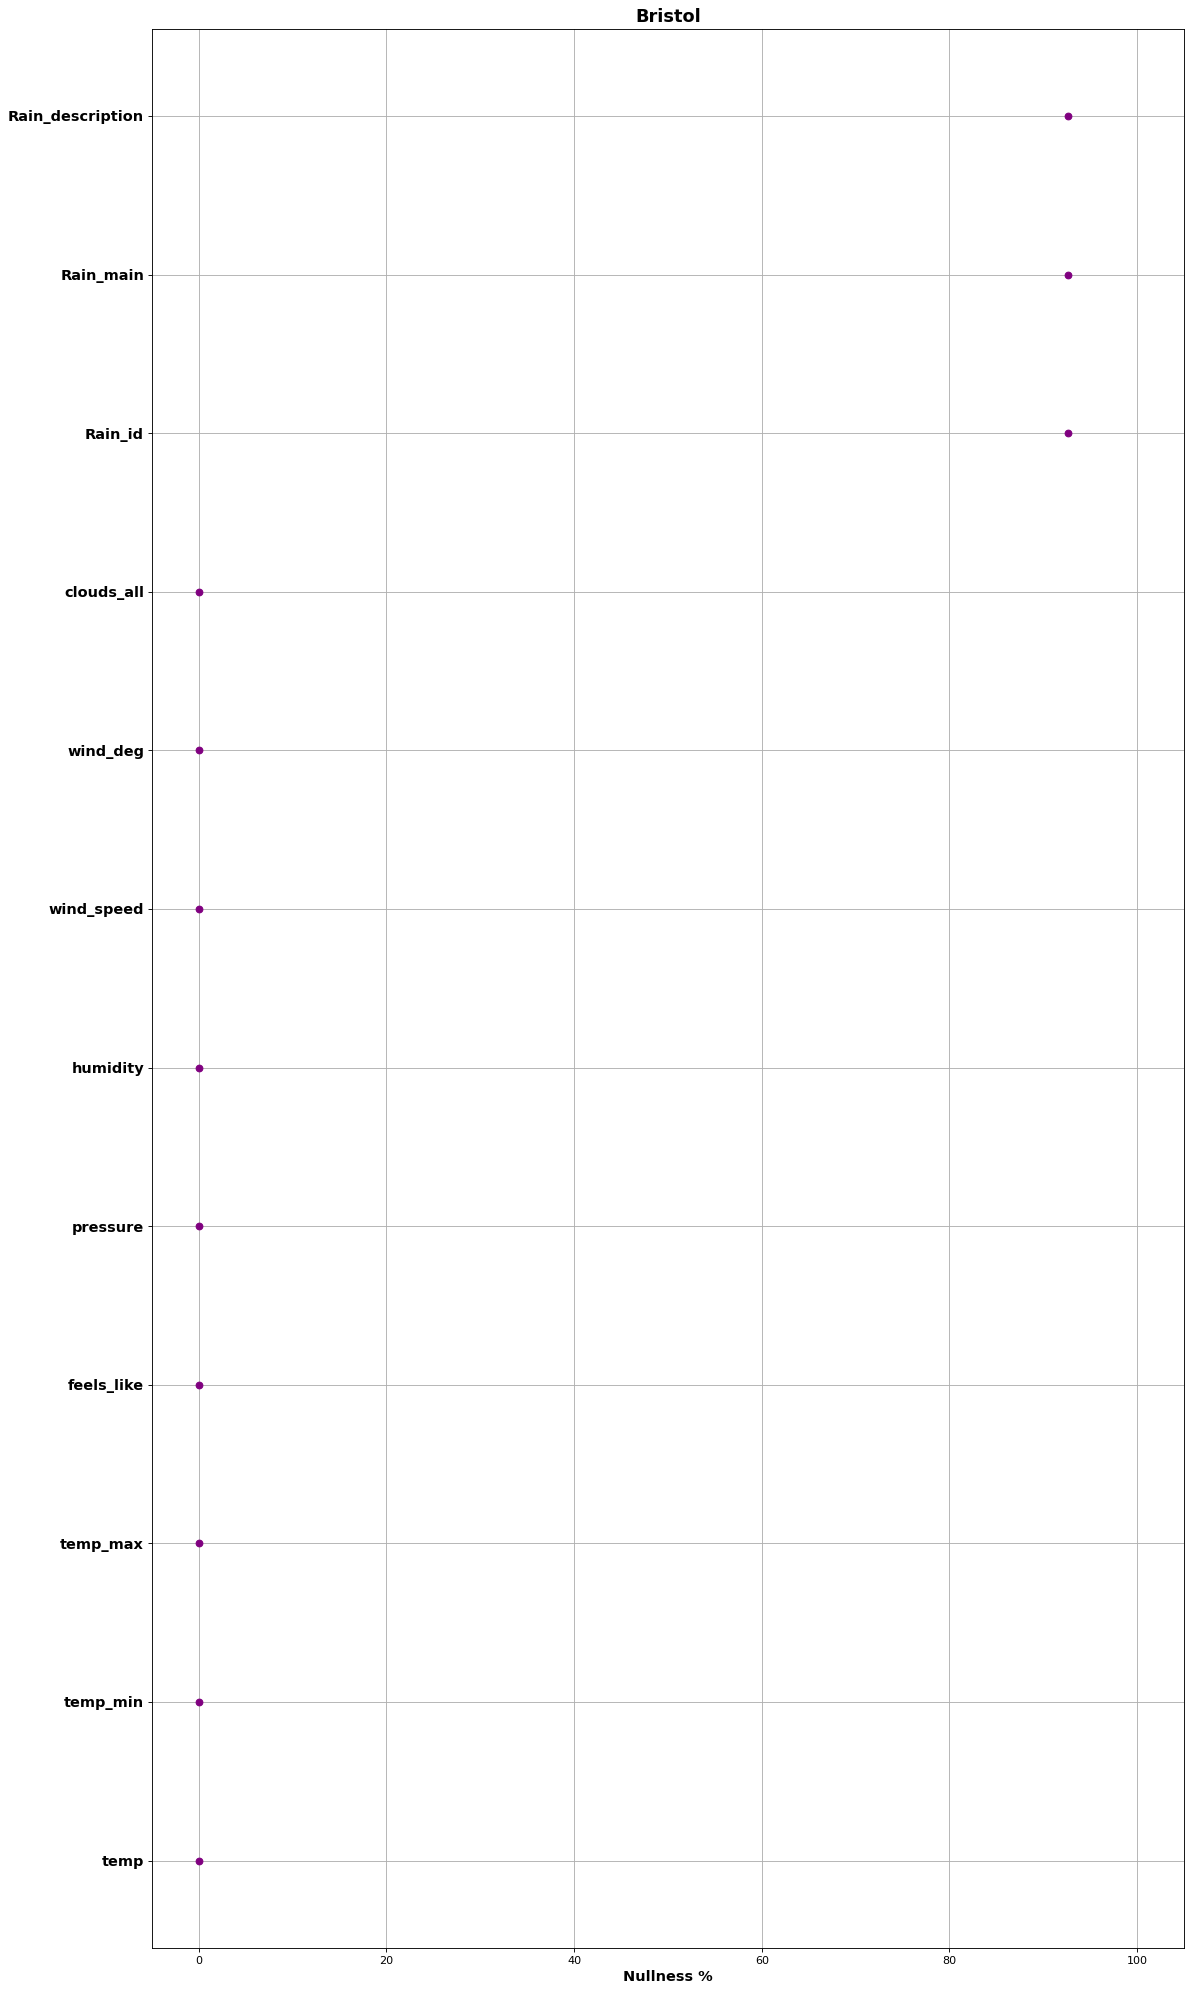

In [11]:
# Plot features nullness(nans)
plot_nullness()